**SkyTalk Decoded: Automated Sentiment Intelligence from Airline Twitter Data**

**Problem Statement**

Airlines receive a massive volume of customer feedback through Twitter in the form of complaints, compliments, and neutral opinions. This feedback is unstructured, noisy, and generated in real time, making manual analysis impractical and inefficient.

 The challenge is to automatically understand and classify customer sentiment expressed in airline-related tweets into meaningful categories (Positive, Neutral, Negative) so that airlines can
1.  Monitor customer satisfaction
2. Identify recurring service issues
3. Make data-driven decisions to improve customer experience

This project aims to solve this problem using **Natural Language Processing (NLP)** combined with **Machine Learning and Deep Learning models** to accurately classify sentiment from raw tweet text.

Project Objectives

The key objectives of this project are:

1. To preprocess and clean noisy Twitter text data

2. To transform unstructured text into numerical features suitable for modeling

3. To build a baseline machine learning model for sentiment classification

4. To optimize the feature space by reducing sparsity and noise

5. To develop a deep learning model capable of capturing complex linguistic patterns

6. To evaluate and compare model performance using standard classification metrics

7. To derive meaningful sentiment insights from airline customer feedback

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from xgboost import XGBClassifier
from tensorflow.keras import Sequential # dl Model
from tensorflow.keras.layers import Dense,Dropout #used to create layers in dl model
from tensorflow.keras import regularizers


In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**Dataset Summary**

Dataset Name: tweets.csv
Source: Publicly available Twitter dataset

Number of Records: 14,640 tweets

Target Variable: airline_sentiment(Positive,Neutral,Negative)

Key Feature Used:

text → raw tweet content posted by airline customers

In [ ]:
df.shape

(14640, 15)

**Target Encoding**

In [ ]:
x=df['text']
y=df['airline_sentiment']

In [ ]:
le=LabelEncoder()
y=le.fit_transform(y) #Applied Label Encoding to convert sentiment categories into numeric labels

In [ ]:
for i in range(5):
  print(x.iloc[i])

@VirginAmerica What @dhepburn said.
@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica I didn't today... Must mean I need to take another trip!
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it


# Text Cleaning
Noise Removal



In [ ]:
x=x.apply(lambda i: re.sub(r'[^a-zA-Z ]',' ',i)).str.lower()
x=x.apply(lambda i :re.sub(r'\bhttp\w+\b',' ',i))

Removed:

Special characters

Numbers

Punctuation

Converted all text to lowercase

Removed URLs using regular expressions

# Tokenization, Stopword Removal & Lemmatization
Tokenized text using NLTK

Removed common stopwords (e.g., the, is, and)

Applied WordNet Lemmatization to convert words to their base form

In [ ]:
le=WordNetLemmatizer()

In [ ]:
stop_words=stopwords.words('english')

In [ ]:
def tokenize_wo_stopwords(text):
  token=word_tokenize(text)
  return ' '.join([le.lemmatize(word,pos='v') for word in token if word not in stop_words])

In [ ]:
x=x.apply(tokenize_wo_stopwords)

# Train–Test Split



In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.75,stratify=y,random_state=42) #Used stratified sampling to preserve sentiment class distribution

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(10980,)
(10980,)
(3660,)
(3660,)


**Text Vectorization using TF-IDF**

Converted cleaned text into numerical vectors using TF-IDF Vectorizer

Captures:

Importance of words within a tweet

Rarity of words across the dataset

In [ ]:
vectorizer=TfidfVectorizer()
tfidf_train_mat=vectorizer.fit_transform(xtrain)
tfidf_test_mat=vectorizer.transform(xtest)
tfidf_train=vectorizer.fit_transform(xtrain)
tfidf_test=vectorizer.transform(xtest)

In [ ]:

x_train=pd.DataFrame(tfidf_train_mat.toarray(),columns=vectorizer.get_feature_names_out())

In [ ]:
x_test=pd.DataFrame(tfidf_test_mat.toarray(),columns=vectorizer.get_feature_names_out())

In [ ]:
x_train.head()

,aa,aaaand,aaadvantage,aaalwayslate,aadavantage,aadelay,aadv,aadvantage,aafail,aal,...,zurich,zut,zv,zvfmxnuelj,zvhco,zwmuoon,zy,zygjs,zz,zzps
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_test.head()

,aa,aaaand,aaadvantage,aaalwayslate,aadavantage,aadelay,aadv,aadvantage,aafail,aal,...,zurich,zut,zv,zvfmxnuelj,zvhco,zwmuoon,zy,zygjs,zz,zzps
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
model_xgb=XGBClassifier(n_estimator=50,max_depth=5)
model_xgb.fit(x_train,ytrain)
pred=model_xgb.predict(x_test)
print(classification_report(ytest,pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:00:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2294
           1       0.64      0.42      0.50       775
           2       0.74      0.61      0.66       591

    accuracy                           0.76      3660
   macro avg       0.72      0.65      0.67      3660
weighted avg       0.75      0.76      0.75      3660



<Axes: >

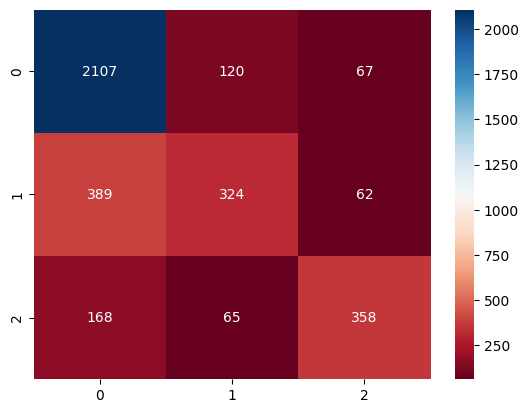

In [ ]:
sns.heatmap(confusion_matrix(ytest,pred),annot=True,cmap='RdBu',fmt='g')

# Feature Optimization

To reduce sparsity and noise, features appearing in less than 0.1% of the training data were removed. This reduced the feature space from 9904 columns to 1174 columns.



In [ ]:
per_data=((x_train!=0).mean(axis=0)*100).sort_values(ascending=False)

In [ ]:
drop_cols=per_data[per_data<0.1].index #Removed features appearing in less than 0.1%

In [ ]:
x_train.drop(columns=drop_cols,inplace=True)
x_test.drop(columns=drop_cols,inplace=True)


In [ ]:
x_train.shape

(10980, 1174)

In [ ]:
x_test.shape

(3660, 1174)

In [ ]:
#re-trained model after feature optimization
model_xgb1=XGBClassifier(n_estimator=50,max_depth=5)
model_xgb1.fit(x_train,ytrain)
pred1=model_xgb1.predict(x_test)
print(classification_report(ytest,pred1))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:19:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.79      0.91      0.85      2294
           1       0.60      0.41      0.49       775
           2       0.74      0.61      0.67       591

    accuracy                           0.76      3660
   macro avg       0.71      0.64      0.67      3660
weighted avg       0.74      0.76      0.74      3660



<Axes: >

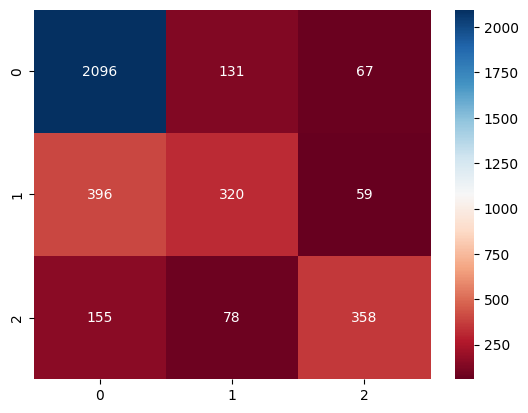

In [ ]:
sns.heatmap(confusion_matrix(ytest,pred1),annot=True,cmap='RdBu',fmt='g')


Row 0
- Model correctly predicted 2096 tweets as Negatives(True Negative)
- 131 Actual negatives were misclassified as Netural
- 67 actual negatives misclassified as Positives

 Row 1:
 - 396 Netural Tweets were misclassified as negatives
 - 320 tweets were correctly predicted as netural
 - 59 Netural tweets were misclassified as Positive

 Row 2:
 - 155 Postive tweets misclassified as Negatives
 - 78 positive were misclassified as neturals
 - 358 tweets were correctly predicted postive


# Netural Networks

In [ ]:
x_train.shape

(10980, 1174)

In [ ]:
pd.Series(ytrain).unique()# muilti class prblm softmax

array([0, 1, 2])

In [ ]:
model=Sequential()
#now we will add input layer n 1st hidden layer
model.add(Dense(2000,input_shape=(1174,),activation='relu',kernel_regularizer=regularizers.l2(0.005)))
#model.add(Dropout(0.2))
#now lets add 2nd hidden layer
model.add(Dense(1000,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
#model.add(Dropout(0.2))

#3rd hidden layer
model.add(Dense(500,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
#model.add(Dropout(0.2))

#4th hidden layer
model.add(Dense(250,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
#model.add(Dropout(0.2))

#Add o/p layer
model.add(Dense(3,activation='softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2000)           │     2,350,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │       125,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           753 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,977,503 (18.99 MB)

 Trainable params: 4,977,503 (18.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#parameters in first hidden layer
print('1st hidden layer',1174*2000+2000)
print('2st hidden layer',1000*2000+1000)
print('3st hidden layer',1000*500+500)
print('Ouput layer',500*3+3)

1st hidden layer 2350000
2st hidden layer 2001000
3st hidden layer 500500
Ouput layer 1503


In [ ]:
#to config we need to complie the model
# regression loss ='RMSE' #binary classsification loss ='binarycrossentropy'
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#train model
model.fit(x_train,ytrain,epochs=10,batch_size=3000)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4351 - loss: 19.2010
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6277 - loss: 15.0239
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6271 - loss: 11.6345
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6289 - loss: 8.9274
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6290 - loss: 6.8233
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6276 - loss: 5.2051
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6254 - loss: 3.9855
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6263 - loss: 3.0768
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6262 - loss: 2.4126
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6227 - loss: 1.9495


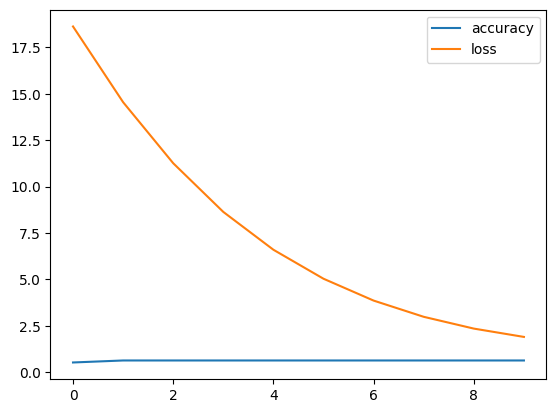

In [ ]:
# we can visualize how the loss has reduced and accuracy has improved
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['loss'])
plt.legend(['accuracy','loss'])
plt.show()

In [ ]:
model.evaluate(x_test,ytest)#3660/32default batch_size

115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6185 - loss: 1.7001


[1.6895517110824585, 0.6267759799957275]

In [ ]:
xtest.shape

(3660,)

In [ ]:
pred_nn=model.predict(x_test)

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [ ]:
pred_nn

array([[0.62265223, 0.2264159 , 0.15093188],
       [0.8516231 , 0.1021613 , 0.04621558],
       [0.3416757 , 0.33111176, 0.32721245],
       ...,
       [0.59876055, 0.2377148 , 0.1635246 ],
       [0.84638244, 0.10534476, 0.04827274],
       [0.5962279 , 0.2388748 , 0.16489732]], dtype=float32)

In [ ]:
#lets get the o/p label from softmax values
pred_nn_label=np.argmax(pred_nn,axis=1)

In [ ]:
print(classification_report(ytest,pred_nn_label)) # 63% accuracy

              precision    recall  f1-score   support

           0       0.63      1.00      0.77      2294
           1       0.00      0.00      0.00       775
           2       0.00      0.00      0.00       591

    accuracy                           0.63      3660
   macro avg       0.21      0.33      0.26      3660
weighted avg       0.39      0.63      0.48      3660



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The model showed a strong bias, classifying almost all samples as 'Negative' (class 0), leading to very low precision and recall for the 'Neutral' (class 1) and 'Positive' (class 2) sentiments.

<Axes: >

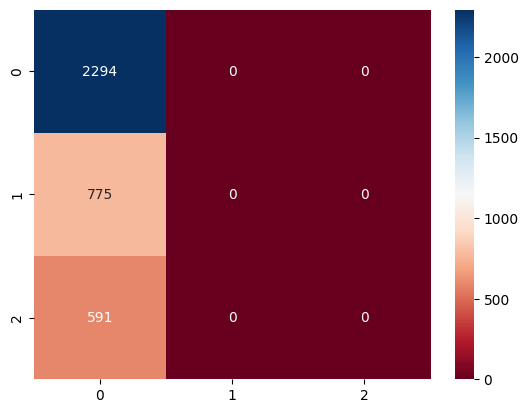

In [ ]:
sns.heatmap(confusion_matrix(ytest,pred_nn_label),annot=True,cmap='RdBu',fmt='g')

While both models were built, the XGBoost Classifier performed significantly better and more balanced across the sentiment categories after feature optimization, making it the more effective model for this task compared to the current neural network implementation.

**Project Conclusion**

This project successfully addressed the challenge of automatically classifying customer sentiment from airline Twitter data into 'Positive', 'Neutral', and 'Negative' categories. By leveraging Natural Language Processing (NLP) techniques alongside Machine Learning and Deep Learning models, the aim was to enable airlines to monitor customer satisfaction, identify service issues, and make data-driven decisions.

* Objectives Achieved:
Preprocessing and Cleaning: Noisy Twitter text data was effectively preprocessed, including noise removal (special characters, numbers, URLs), tokenization, stopword removal, and lemmatization.
Feature Transformation: Unstructured text was transformed into numerical features using TF-IDF vectorization.

* Baseline Model Development: A baseline Machine Learning model (XGBoost Classifier) was successfully built for sentiment classification.
Feature Optimization: The feature space was optimized by removing features appearing in less than 0.1% of the data, reducing dimensionality from 9904 to 1174 features.
* Deep Learning Model Development: A multi-layered Neural Network was developed to explore its capability in capturing complex linguistic patterns.
* Model Evaluation and Comparison: Both models were rigorously evaluated using standard classification metrics (accuracy, precision, recall, f1-score) and confusion matrices.

# Key Findings and Model Performance:
Two primary models were developed and evaluated:

**XGBoost Classifier**: This model demonstrated strong performance, achieving an overall accuracy of 76%. It showed a balanced ability to classify all three sentiment categories, with particularly high precision and recall for 'Negative' sentiment, while also performing reasonably well for 'Neutral' and 'Positive' sentiments. Feature optimization helped refine the model but did not drastically alter its overall performance.

**Neural Network**: The developed Neural Network, despite its sophisticated architecture, achieved a lower overall accuracy of 63% and exhibited a significant bias. It predominantly classified tweets as 'Negative', failing to effectively distinguish between 'Neutral' and 'Positive' sentiments (resulting in 0% precision and recall for these classes). This indicated that, in its current configuration, it was not suitable for this multi-class classification task.

**Conclusion on Model Effectiveness**

The **XGBoost Classifier**(after feature optimization) emerged as the superior model for this project due to its higher accuracy and more balanced performance across all sentiment categories. It proved to be a more robust and reliable solution for understanding airline customer feedback from Twitter data.

